## Problem set 2
#### Daniela del Río

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
''' Function given by Prof. Jacob Robnson for modelling a neuron with Hodgkin & Huxley.
    Code available in file: HodHux_ELEC380.py
'''
def HodHux_ELEC380(I, dt, plot_activation = 0): 
    #Hodgkin Huxley model of a neuron
    #ELEC 480 Fall 2014
    #JTRobinson
    #
    #Converted from MATLAB to Python by CATuppen Fall 2021
    #
    #Input:
    #I = a vector of current values [uA]
    #dt = time step between I measurments [ms]
    #plot_activation (optional) = 1 to plot the activation state variables vs V (default 0)
    #
    #Output:
    #V = membrane voltage in mV
    #n = sodium activation
    #m = potassium activation
    #h = 1 - potassium inactivation
    #
    #State variables: V, n, m, h
    #
    #DV = 1/C (I - Ik - Ina - Il)
    # 
    # Il = gl(V-El)
    # Ik = gk*n^4(V-Ek)
    # Ina = gna*m^3*h(V-Ena)
    #
    #Dn = (ninf(V) - n)/taun(V)
    #Dm = (minf(V) - m)/taum(V)
    #Dh = (hinf(V) - h)/tauh(V)

    global V
    global m
    global n
    global h
    global gkt
    global gnat
    global Ik
    global Ina
    global Il

    #starting membrane potential;
    Vstart = -65.625 #[mV]

    #Constants:
    #reversal potentials for various ions
    Ek = -77 #[mV]
    Ena = 50 #[mV] 
    El = -54.4 #[mV] H&H used approx -55 mV

    #Membrane capacitance:
    C = 1 #[uF]

    #maximum conductances [mS]
    gna = 120
    gk = 36
    gl = 0.3

    #Constants for GHK eq for channel activation
    #from J. Bossu, J Physiol. 496.2 (1996)
    #V50n = 57;
    #kn = 13.5;

    #from Izhikevich pg. 46 (2007)
    #K+ Delayed Rectifier 1: Ik = g*n^4*(V-Ek)

    #activation
    V50n = -50
    kn = 15

    Vmaxn = -79
    sig_n = 50
    Campn = 4.7
    Cbasen = 1.1

    #from Izhikevich pg. 46 (2007)
    #Na+ Fast Transient 1: Ina = g*m^3*h*(V-Ena)

    #activation:
    V50m = -40
    km = 8 #adjusted to match Fig. 2.3 on Pg. 39. probably a typo in the table 

    Vmaxm = -38
    sig_m = 30
    Campm = 0.46
    Cbasem = 0.04

    #inactivation
    V50h = -60
    kh = -7

    Vmaxh = -67
    sig_h = 20
    Camph = 7.4
    Cbaseh = 1.2

    #initialize the vector sizes
    n = np.zeros(len(I))
    m = np.zeros(len(I))
    h = np.zeros(len(I))
    V = np.zeros(len(I))

    #set initial conditions:
    n[0] = 0.3
    m[0] = 0.006
    h[0] = 0.626
    V[0] = Vstart #[mV]
    
    #iterate through the input sequence and calculate the response
    for ii in range(len(I)-1):
        
        #display progress (can remove this block if desired)
        if (ii % 1000) == 0:
            print(ii)
            print(V[ii],n[ii],m[ii],h[ii])

        #update voltage state variable
        #DV = 1/C (I - Ik - Ina - Il)
        
        #units: 
        #I = uA
        #V = mV, g = mS; g*V = uA
        #C = uF 
        #uA/uC*ms = mV
       
        #full model
        V[ii+1] = V[ii] + dt/C*(I[ii] - gl*(V[ii]-El) - gk*n[ii]**4*(V[ii]-Ek) 
                                - gna*m[ii]**3*h[ii]*(V[ii]-Ena))
        
        #steady state activation values at the given voltage
        ninf = 1/( 1 + np.exp( (V50n-V[ii])/kn ) )
        minf = 1/( 1 + np.exp( (V50m-V[ii])/km ) )
        hinf = 1/( 1 + np.exp( (V50h-V[ii])/kh ) )
        
        #time constants
        #Izhikevich pg. 45
        taun = Cbasen + Campn*np.exp(-(Vmaxn-V[ii])**2/sig_n**2)
        taum = Cbasem + Campm*np.exp(-(Vmaxm-V[ii])**2/sig_m**2)
        tauh = Cbaseh + Camph*np.exp(-(Vmaxh-V[ii])**2/sig_h**2)
        
        #update activation state variables
        n[ii+1] = n[ii] + dt*(ninf - n[ii])/taun
        m[ii+1] = m[ii] + dt*(minf - m[ii])/taum
        h[ii+1] = h[ii] + dt*(hinf - h[ii])/tauh
        
    gkt = gk*n**4
    gnat = gna*m**3*h

    Ik = gkt*(V-Ek)
    Ina = gnat*(V-Ena)
    Il = gl*(V-El)

    #Diagnostics
    if plot_activation:
        print("The time step is: ",dt)
        Vtest = np.arange(-100,11) # The x-vector is this one, that is why there are negatives in the x-axis
                                    # I am not sure if this is supposed to be time or voltage, though...

        #steady state activation vs Voltage
        ninfV = 1/( 1 + np.exp((V50n-Vtest)/kn))
        minfV = 1/( 1 + np.exp((V50m-Vtest)/km))
        hinfV = 1/( 1 + np.exp((V50h-Vtest)/kh))

        line1, = plt.plot(Vtest, ninfV, color = 'b', label = r'$n_{infty}$')
        line2, = plt.plot(Vtest, minfV, color = 'r', label = r'$m_{infty}$')
        line3, = plt.plot(Vtest, hinfV, color = 'k', label = r'$h_{infty}$')
        plt.legend(handles=[line1, line2, line3])
        plt.suptitle('Steady state activations')
        plt.xlabel("Time [ms]")
        plt.show()
         
        #time constants vs Voltage
        taunV = Cbasen + Campn*np.exp(-(Vmaxn-Vtest)**2/sig_n**2)
        taumV = Cbasem + Campm*np.exp(-(Vmaxm-Vtest)**2/sig_m**2)
        tauhV = Cbaseh + Camph*np.exp(-(Vmaxh-Vtest)**2/sig_h**2)

        line1, = plt.plot(Vtest, taunV, color = 'b', label = r'$tau_{n}$')
        line2, = plt.plot(Vtest, taumV, color = 'r', label = r'$tau_{m}$')
        line3, = plt.plot(Vtest, tauhV, color = 'k', label = r'$tau_{h}$')
        plt.xlabel("Time [ms]")
#         plt.ylabel("Activation time constants")
        plt.suptitle('Activation time constants')
        plt.legend(handles=[line1, line2, line3])
        plt.show()

## The following plots are membrane potential vs. time.
Not quite sure about the membrane potential in the first kind of plots, though.

# Another question, what values are the output of the function?

0
-65.625 0.3 0.006 0.626
The time step is:  0.1


<ipython-input-14-83071b5ce9f1>:135: RuntimeWarning: overflow encountered in exp
  hinf = 1/( 1 + np.exp( (V50h-V[ii])/kh ) )
<ipython-input-14-83071b5ce9f1>:133: RuntimeWarning: overflow encountered in exp
  ninf = 1/( 1 + np.exp( (V50n-V[ii])/kn ) )
<ipython-input-14-83071b5ce9f1>:134: RuntimeWarning: overflow encountered in exp
  minf = 1/( 1 + np.exp( (V50m-V[ii])/km ) )
<ipython-input-14-83071b5ce9f1>:139: RuntimeWarning: overflow encountered in double_scalars
  taun = Cbasen + Campn*np.exp(-(Vmaxn-V[ii])**2/sig_n**2)
<ipython-input-14-83071b5ce9f1>:140: RuntimeWarning: overflow encountered in double_scalars
  taum = Cbasem + Campm*np.exp(-(Vmaxm-V[ii])**2/sig_m**2)
<ipython-input-14-83071b5ce9f1>:141: RuntimeWarning: overflow encountered in double_scalars
  tauh = Cbaseh + Camph*np.exp(-(Vmaxh-V[ii])**2/sig_h**2)
<ipython-input-14-83071b5ce9f1>:130: RuntimeWarning: overflow encountered in double_scalars
  - gna*m[ii]**3*h[ii]*(V[ii]-Ena))
<ipython-input-14-83071b5ce9f1>:129: Runt

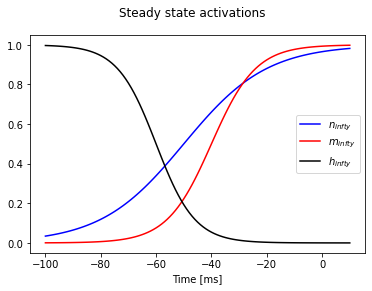

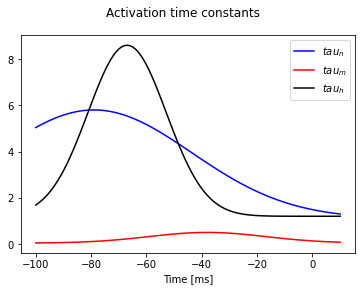

0
-65.625 0.3 0.006 0.626
The time step is:  0.01


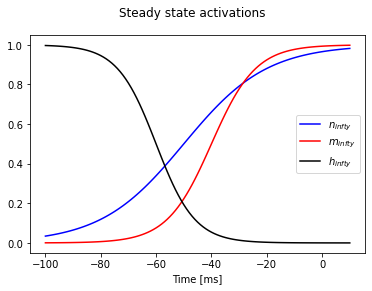

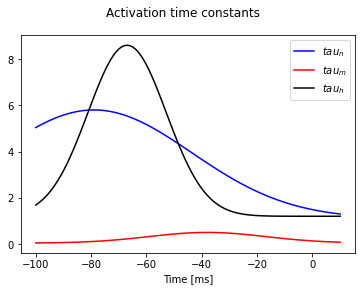

0
-65.625 0.3 0.006 0.626
The time step is:  0.001


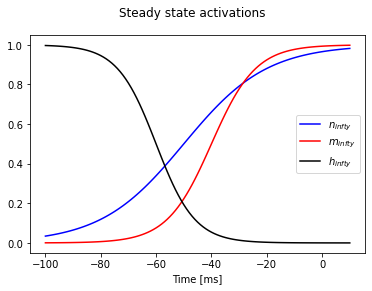

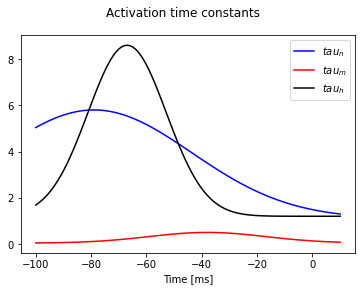

In [15]:
#Trying out the previous function
Is = np.zeros(1000)
Is[200:800] = 10 # 60 ms of 10 uA current pulse, from 
dts = [0.1, 0.01, 0.001]

for i in range(len(dts)):
    HodHux_ELEC380(Is, dts[i], 1)

## Exercises 1.3-1.6

In [32]:
length = 6001
x_range = [i/100 for i in range(length)]
x_range[length - 1] # 60 ms


t1 = 200
t2 = 5000

current = np.zeros(length)
current[t1:t2] = 2 # [t1,t2] interval of 2 uA current pulse

For checking to see if an action potential occured, see that the maximum voltage was above a certain value.

For the transmembrane current, Anne said "Transmembrane current is the current across the membrane. You can calculate that based on some of the outputs of the function. Based on the circuit drawing you created in 1.1, which function outputs could be used to calculate transmembrane current?"

The output of the ``HodHux_ELEC380`` function:

- ``V`` = membrane voltage in mV
- ``n`` = sodium activation
- ``m`` = potassium activation
- ``h`` = 1 - potassium inactivation

In [33]:
HodHux_ELEC380(current, 0.01, 0)

0
-65.625 0.3 0.006 0.626
1000
-74.90332433291564 0.755537710938499 0.11240373955726919 0.11565141613337541
2000
-64.12298365356786 0.31231451912175795 0.044998665510541005 0.5975066518573896
3000
-59.46133212294793 0.3468678610849762 0.08478723037188064 0.5085138892964178
4000
-60.63031532208318 0.3175847373999679 0.06962027432322479 0.5504087114293105
5000
-61.685494591302955 0.32121868658008196 0.06225534627896623 0.5418955475040861
